In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

city = 'AL_Maceio'

Using TensorFlow backend.


In [2]:
def getFileNameIn(path):
    files_names = []
    for dirname, dirnames, filenames in os.walk(path):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            files_names.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            files_names.append(os.path.join(dirname, filename))
        
        return files_names

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.fillna(0, inplace=True)
    
    dataset.drop('Precipitacao', axis=1, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
    
    output_path = '../data_out/' + data_input_path[11:]
    # save file
    dataset.to_csv(output_path)
    
    return output_path

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

In [6]:
# plot each column in a graph
def plot_columns(dataset, values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,7)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,7)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,7)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,7)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler.inverse_transform(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler.inverse_transform(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests, days_to_predict):
    temps_splited = splitTemperature(y_hats, y_tests, city)
    y_hats_max = temps_splited[0]
    y_tests_max = temps_splited[1]
    y_hats_min = temps_splited[2]
    y_tests_min = temps_splited[3]
    
    errors_max = abs(np.subtract(y_hats_max,y_tests_max))
    errors_min = abs(np.subtract(y_hats_min,y_tests_min))
    
    print('Maximum temperatures metrics')
    printMetrics(errors_max, 'max', city)
    day_errors(days_to_predict, errors_max, city)
    accuracy(errors_max, city)
    
    print('\nMinimum temperatures metrics')
    printMetrics(errors_min, 'min', city)
    day_errors(days_to_predict, errors_min, city)
    accuracy(errors_min, city)

In [12]:
def splitTemperature(y_hats, y_tests, city):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    for y in y_hats:
        y_hats_max.append(y[0])
        y_hats_min.append(y[1])
        
    for y in y_tests:
        y_tests_max.append(y[0])
        y_tests_min.append(y[1])
    
    file_path = '../results/'+city+'_std_normalization_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    for i,j,k,l in zip(y_hats_max, y_tests_max, y_hats_min, y_tests_min):
        content.append('{},{},{},{}\n'.format(i,j,k,l))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()
    
    return [y_hats_max, y_tests_max, y_hats_min, y_tests_min]

In [13]:
def printMetrics(errors, temperature, city):
    mse = np.mean(np.square(errors))
    std = np.std(errors)
    meanAbsolutError = np.mean(errors)
    medianAbsoluteError = np.median(errors)
    
    file_path = '../results/'+city+'_std_normalization_metrics_results.csv'
    if temperature == 'max':
        file = open(file_path, 'r')
        content = file.readlines()

        content.append('{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError))

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    elif temperature == 'min':
        file = open(file_path, 'r')
        content = file.readlines()
        
        content[1] = content[1].replace('\n', ',')+'{},{},{},{}\n'.format(mse,std,meanAbsolutError,medianAbsoluteError)

        file = open(file_path, 'w')
        file.writelines(content)
        file.close()
    
    print('Test MEAN-SQUARED-ERROR ------------ {:.4}'.format(mse))
    print('Test STANDART-DEVIATION ------------ {:.4}'.format(std))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError))

In [14]:
def accuracy(errors, city):
    j = 1
    sum_percentual = 0
    accuracys = []
    sets = []
    
    print('\nAccuracy')
    while sum_percentual <= 99:
        count = 0
        n = len(errors)
        
        for error in errors:
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = (count/n)*100
        sum_percentual += percentual
        if percentual > 0:
            accuracys.append(percentual)
            sets.append('({}, {}]'.format(j-1, j))
            print('{:.2f}% of predictions missed between ({}, {}] point(s)'.format(percentual, j-1, j))
        j += 1
    print('\n')
    
    file_path = '../results/'+city+'_std_normalization_accuracy_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()

    for i,j in zip(accuracys, sets):
        content.append('{},{}\n'.format(i,j))

    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

In [15]:
def day_errors(days_to_predict, errors, city):
    i = 0
    
    file_path = '../results/'+city+'_std_normalization_predictions_results.csv'
    file = open(file_path, 'r')
    content = file.readlines()
    
    print('\nErrors')
    for error in errors:
        content[i+1] = content[i+1].replace('\n', ',')+'{}\n'.format(error)
        print('{} = {}'.format(days_to_predict[29-i],error))
        i += 1
    
    file = open(file_path, 'w')
    file.writelines(content)
    file.close()

            TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                              
2014-01-01        30.9        22.2       10.5               3.0   
2014-01-02        30.9        22.3       10.4               4.6   
2014-01-03        31.1        21.1        8.2               3.2   
2014-01-04        32.4        22.8       10.6               4.6   
2014-01-05        30.6        21.9        7.9               4.4   
...                ...         ...        ...               ...   
2018-12-27        33.4        23.6        9.9               2.8   
2018-12-28        33.0        23.6        9.6               2.8   
2018-12-29        33.2        23.4        8.7               2.8   
2018-12-30        33.0        23.1        3.4               2.8   
2018-12-31        32.2        23.3        9.6               2.8   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                           

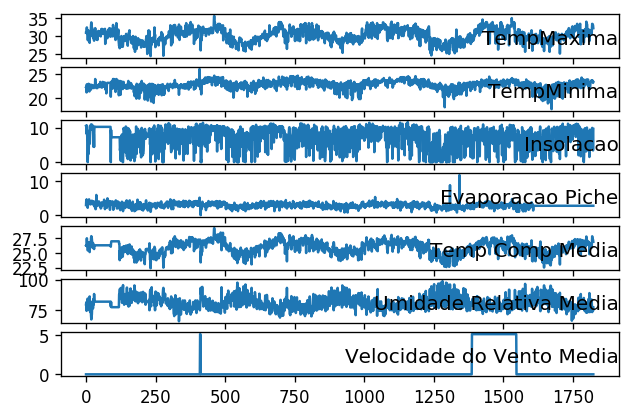

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6663 - mean_squared_error: 0.7691 - val_loss: 0.8358 - val_mean_squared_error: 1.1840
Epoch 2/1000
 - 1s - loss: 0.6190 - mean_squared_error: 0.6654 - val_loss: 0.9804 - val_mean_squared_error: 1.5202
Epoch 3/1000
 - 1s - loss: 0.6029 - mean_squared_error: 0.6372 - val_loss: 0.9248 - val_mean_squared_error: 1.3310
Epoch 4/1000
 - 1s - loss: 0.5947 - mean_squared_error: 0.6252 - val_loss: 0.8923 - val_mean_squared_error: 1.3282
Epoch 5/1000
 - 1s - loss: 0.5928 - mean_squared_error: 0.6225 - val_loss: 0.8164 - val_mean_squared_error: 1.0778
Epoch 6/1000
 - 1s - loss: 0.5869 - mean_squared_error: 0.6116 - val_loss: 0.8782 - val_mean_squared_error: 1.2483
Epoch 7/1000
 - 0s - loss: 0.5817 - mean_squared_error: 0.5959 - val_loss: 0.7963 - val_mean_squared_error: 1.1534
Epoch 8/1000
 - 0s - loss: 0.5794 - mean_squared_error: 0.5978 - val_loss: 0.7631 - val_mean_squared_error: 1.0224
Epoch 9/1000
 - 1s - loss: 0.5756 -

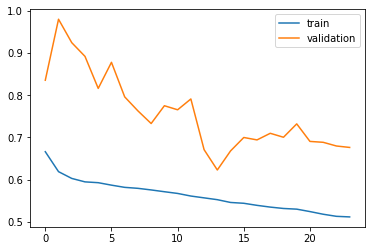


predict: [[31.8484766  23.19512956]]
real:      [[32.2 23.3]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6829 - mean_squared_error: 0.8058 - val_loss: 0.9902 - val_mean_squared_error: 1.1856
Epoch 2/1000
 - 0s - loss: 0.6243 - mean_squared_error: 0.6776 - val_loss: 1.1356 - val_mean_squared_error: 1.4856
Epoch 3/1000
 - 1s - loss: 0.6045 - mean_squared_error: 0.6441 - val_loss: 1.0742 - val_mean_squared_error: 1.3705
Epoch 4/1000
 - 1s - loss: 0.5966 - mean_squared_error: 0.6287 - val_loss: 1.0631 - val_mean_squared_error: 1.3440
Epoch 5/1000
 - 0s - loss: 0.5910 - mean_squared_error: 0.6228 - val_loss: 1.0149 - val_mean_squared_error: 1.2619
Epoch 6/1000
 - 1s - loss: 0.5862 - mean_squared_error: 0.6127 - val_loss: 1.0623 - val_mean_squared_error: 1.3621
Epoch 7/1000
 - 1s - loss: 0.5833 - mean_squared_error: 0.6119 - val_loss: 0.9745 - val_mean_squared_error: 1.2068
Epoch 8/1000
 - 1s - loss: 0.5775 - mean_squared_error: 0.6055 - val_loss: 0.8767 - va

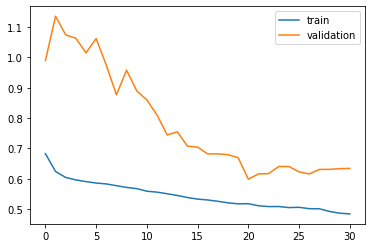


predict: [[30.78667497 23.02957171]]
real:      [[33.  23.1]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6948 - mean_squared_error: 0.8434 - val_loss: 1.1422 - val_mean_squared_error: 1.3834
Epoch 2/1000
 - 1s - loss: 0.6204 - mean_squared_error: 0.6819 - val_loss: 1.2289 - val_mean_squared_error: 1.6014
Epoch 3/1000
 - 0s - loss: 0.6040 - mean_squared_error: 0.6459 - val_loss: 1.1753 - val_mean_squared_error: 1.4664
Epoch 4/1000
 - 0s - loss: 0.5970 - mean_squared_error: 0.6282 - val_loss: 1.1781 - val_mean_squared_error: 1.4848
Epoch 5/1000
 - 0s - loss: 0.5924 - mean_squared_error: 0.6246 - val_loss: 1.1451 - val_mean_squared_error: 1.4077
Epoch 6/1000
 - 1s - loss: 0.5878 - mean_squared_error: 0.6209 - val_loss: 1.0962 - val_mean_squared_error: 1.2991
Epoch 7/1000
 - 1s - loss: 0.5870 - mean_squared_error: 0.6110 - val_loss: 1.1086 - val_mean_squared_error: 1.3402
Epoch 8/1000
 - 1s - loss: 0.5812 - mean_squared_error: 0.6091 - val_loss: 1.0756 - va

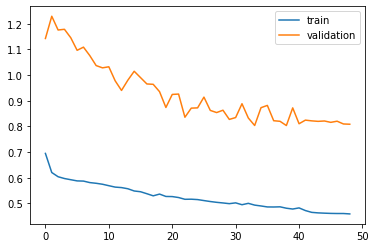


predict: [[30.84607863 22.92475836]]
real:      [[33.2 23.4]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6968 - mean_squared_error: 0.8295 - val_loss: 1.2193 - val_mean_squared_error: 1.7406
Epoch 2/1000
 - 1s - loss: 0.6210 - mean_squared_error: 0.6751 - val_loss: 1.3769 - val_mean_squared_error: 2.1462
Epoch 3/1000
 - 1s - loss: 0.6050 - mean_squared_error: 0.6439 - val_loss: 1.3534 - val_mean_squared_error: 2.0493
Epoch 4/1000
 - 1s - loss: 0.5976 - mean_squared_error: 0.6350 - val_loss: 1.2865 - val_mean_squared_error: 1.8621
Epoch 5/1000
 - 1s - loss: 0.5925 - mean_squared_error: 0.6276 - val_loss: 1.2449 - val_mean_squared_error: 1.7463
Epoch 6/1000
 - 1s - loss: 0.5898 - mean_squared_error: 0.6211 - val_loss: 1.2442 - val_mean_squared_error: 1.7510
Epoch 7/1000
 - 1s - loss: 0.5835 - mean_squared_error: 0.6166 - val_loss: 1.2566 - val_mean_squared_error: 1.7861
Epoch 8/1000
 - 1s - loss: 0.5790 - mean_squared_error: 0.6031 - val_loss: 1.2267 - va

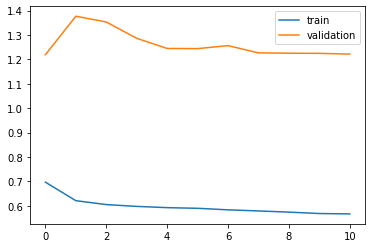


predict: [[31.06467822 23.14694811]]
real:      [[33.  23.6]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7143 - mean_squared_error: 0.8341 - val_loss: 0.8858 - val_mean_squared_error: 0.7963
Epoch 2/1000
 - 1s - loss: 0.6314 - mean_squared_error: 0.6881 - val_loss: 0.9565 - val_mean_squared_error: 0.9244
Epoch 3/1000
 - 1s - loss: 0.6108 - mean_squared_error: 0.6577 - val_loss: 0.9017 - val_mean_squared_error: 0.8198
Epoch 4/1000
 - 1s - loss: 0.6028 - mean_squared_error: 0.6432 - val_loss: 0.8685 - val_mean_squared_error: 0.7622
Epoch 5/1000
 - 1s - loss: 0.5956 - mean_squared_error: 0.6313 - val_loss: 0.7765 - val_mean_squared_error: 0.6164
Epoch 6/1000
 - 1s - loss: 0.5928 - mean_squared_error: 0.6269 - val_loss: 0.7362 - val_mean_squared_error: 0.5531
Epoch 7/1000
 - 1s - loss: 0.5866 - mean_squared_error: 0.6233 - val_loss: 0.6972 - val_mean_squared_error: 0.4920
Epoch 8/1000
 - 1s - loss: 0.5854 - mean_squared_error: 0.6184 - val_loss: 0.7634 - va

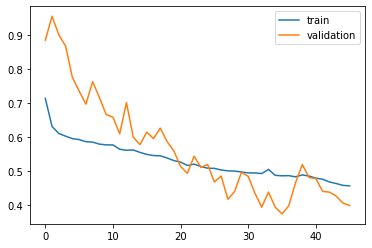


predict: [[31.42455221 23.11771834]]
real:      [[33.4 23.6]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6839 - mean_squared_error: 0.7759 - val_loss: 0.4099 - val_mean_squared_error: 0.2005
Epoch 2/1000
 - 1s - loss: 0.6209 - mean_squared_error: 0.6748 - val_loss: 0.3679 - val_mean_squared_error: 0.1786
Epoch 3/1000
 - 1s - loss: 0.6078 - mean_squared_error: 0.6538 - val_loss: 0.3750 - val_mean_squared_error: 0.2650
Epoch 4/1000
 - 1s - loss: 0.5988 - mean_squared_error: 0.6429 - val_loss: 0.4054 - val_mean_squared_error: 0.2706
Epoch 5/1000
 - 1s - loss: 0.5956 - mean_squared_error: 0.6336 - val_loss: 0.4092 - val_mean_squared_error: 0.3042
Epoch 6/1000
 - 1s - loss: 0.5922 - mean_squared_error: 0.6315 - val_loss: 0.5208 - val_mean_squared_error: 0.4110
Epoch 7/1000
 - 1s - loss: 0.5900 - mean_squared_error: 0.6273 - val_loss: 0.4272 - val_mean_squared_error: 0.3022
Epoch 8/1000
 - 1s - loss: 0.5850 - mean_squared_error: 0.6186 - val_loss: 0.4139 - va

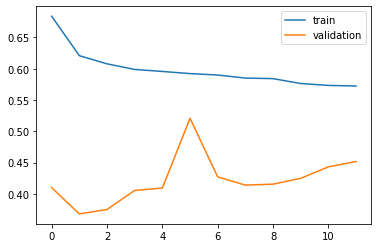


predict: [[31.37261931 23.26693644]]
real:      [[32.  23.5]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6955 - mean_squared_error: 0.8359 - val_loss: 0.4756 - val_mean_squared_error: 0.3014
Epoch 2/1000
 - 1s - loss: 0.6248 - mean_squared_error: 0.6809 - val_loss: 0.5431 - val_mean_squared_error: 0.3569
Epoch 3/1000
 - 1s - loss: 0.6127 - mean_squared_error: 0.6645 - val_loss: 0.5742 - val_mean_squared_error: 0.3954
Epoch 4/1000
 - 1s - loss: 0.6052 - mean_squared_error: 0.6485 - val_loss: 0.5180 - val_mean_squared_error: 0.3353
Epoch 5/1000
 - 1s - loss: 0.6003 - mean_squared_error: 0.6392 - val_loss: 0.4977 - val_mean_squared_error: 0.3343
Epoch 6/1000
 - 1s - loss: 0.5966 - mean_squared_error: 0.6363 - val_loss: 0.4644 - val_mean_squared_error: 0.3464
Epoch 7/1000
 - 1s - loss: 0.5918 - mean_squared_error: 0.6298 - val_loss: 0.4370 - val_mean_squared_error: 0.3266
Epoch 8/1000
 - 1s - loss: 0.5934 - mean_squared_error: 0.6334 - val_loss: 0.4137 - va

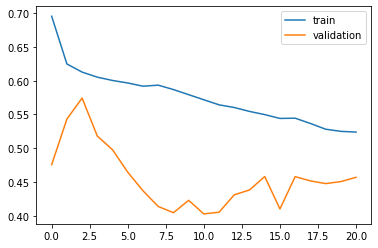


predict: [[31.42157525 23.22029041]]
real:      [[30.5 23.6]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6718 - mean_squared_error: 0.7662 - val_loss: 0.4074 - val_mean_squared_error: 0.1972
Epoch 2/1000
 - 1s - loss: 0.6212 - mean_squared_error: 0.6727 - val_loss: 0.5383 - val_mean_squared_error: 0.3119
Epoch 3/1000
 - 1s - loss: 0.6077 - mean_squared_error: 0.6534 - val_loss: 0.5006 - val_mean_squared_error: 0.2735
Epoch 4/1000
 - 1s - loss: 0.6022 - mean_squared_error: 0.6457 - val_loss: 0.4238 - val_mean_squared_error: 0.1982
Epoch 5/1000
 - 1s - loss: 0.5984 - mean_squared_error: 0.6392 - val_loss: 0.4478 - val_mean_squared_error: 0.2123
Epoch 6/1000
 - 1s - loss: 0.5951 - mean_squared_error: 0.6358 - val_loss: 0.4302 - val_mean_squared_error: 0.1936
Epoch 7/1000
 - 1s - loss: 0.5895 - mean_squared_error: 0.6251 - val_loss: 0.3659 - val_mean_squared_error: 0.1436
Epoch 8/1000
 - 1s - loss: 0.5861 - mean_squared_error: 0.6240 - val_loss: 0.3040 - va

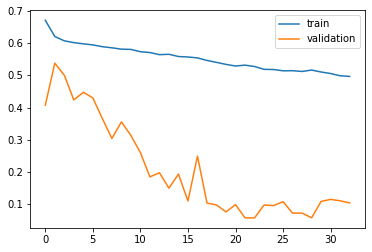


predict: [[31.10216018 23.02352052]]
real:      [[30.5 23.6]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6894 - mean_squared_error: 0.8075 - val_loss: 0.3414 - val_mean_squared_error: 0.1298
Epoch 2/1000
 - 1s - loss: 0.6215 - mean_squared_error: 0.6782 - val_loss: 0.4932 - val_mean_squared_error: 0.2587
Epoch 3/1000
 - 1s - loss: 0.6093 - mean_squared_error: 0.6571 - val_loss: 0.5752 - val_mean_squared_error: 0.3499
Epoch 4/1000
 - 1s - loss: 0.6028 - mean_squared_error: 0.6510 - val_loss: 0.5651 - val_mean_squared_error: 0.3358
Epoch 5/1000
 - 1s - loss: 0.5993 - mean_squared_error: 0.6394 - val_loss: 0.5215 - val_mean_squared_error: 0.2846
Epoch 6/1000
 - 1s - loss: 0.5940 - mean_squared_error: 0.6391 - val_loss: 0.5801 - val_mean_squared_error: 0.3571
Epoch 7/1000
 - 1s - loss: 0.5916 - mean_squared_error: 0.6312 - val_loss: 0.5441 - val_mean_squared_error: 0.3087
Epoch 8/1000
 - 1s - loss: 0.5882 - mean_squared_error: 0.6246 - val_loss: 0.5941 - va

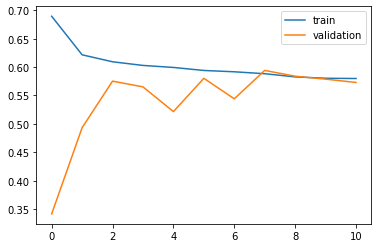


predict: [[30.96400667 23.13360381]]
real:      [[30.8 23.3]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6536 - mean_squared_error: 0.7313 - val_loss: 0.2675 - val_mean_squared_error: 0.0743
Epoch 2/1000
 - 1s - loss: 0.6139 - mean_squared_error: 0.6680 - val_loss: 0.4073 - val_mean_squared_error: 0.1705
Epoch 3/1000
 - 1s - loss: 0.6068 - mean_squared_error: 0.6543 - val_loss: 0.3762 - val_mean_squared_error: 0.1445
Epoch 4/1000
 - 1s - loss: 0.6028 - mean_squared_error: 0.6452 - val_loss: 0.3267 - val_mean_squared_error: 0.1088
Epoch 5/1000
 - 1s - loss: 0.5998 - mean_squared_error: 0.6416 - val_loss: 0.2483 - val_mean_squared_error: 0.0619
Epoch 6/1000
 - 1s - loss: 0.5944 - mean_squared_error: 0.6343 - val_loss: 0.2998 - val_mean_squared_error: 0.0920
Epoch 7/1000
 - 1s - loss: 0.5932 - mean_squared_error: 0.6336 - val_loss: 0.3062 - val_mean_squared_error: 0.0975
Epoch 8/1000
 - 1s - loss: 0.5926 - mean_squared_error: 0.6294 - val_loss: 0.2461 - va

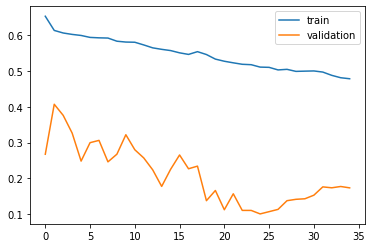


predict: [[31.35623895 23.13816008]]
real:      [[31.  23.4]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7146 - mean_squared_error: 0.8550 - val_loss: 0.2672 - val_mean_squared_error: 0.0722
Epoch 2/1000
 - 1s - loss: 0.6279 - mean_squared_error: 0.6880 - val_loss: 0.1766 - val_mean_squared_error: 0.0441
Epoch 3/1000
 - 1s - loss: 0.6174 - mean_squared_error: 0.6700 - val_loss: 0.2882 - val_mean_squared_error: 0.0854
Epoch 4/1000
 - 1s - loss: 0.6090 - mean_squared_error: 0.6564 - val_loss: 0.3226 - val_mean_squared_error: 0.1144
Epoch 5/1000
 - 1s - loss: 0.6041 - mean_squared_error: 0.6540 - val_loss: 0.2478 - val_mean_squared_error: 0.0680
Epoch 6/1000
 - 1s - loss: 0.6027 - mean_squared_error: 0.6519 - val_loss: 0.3065 - val_mean_squared_error: 0.1105
Epoch 7/1000
 - 1s - loss: 0.6000 - mean_squared_error: 0.6462 - val_loss: 0.2809 - val_mean_squared_error: 0.0892
Epoch 8/1000
 - 1s - loss: 0.5927 - mean_squared_error: 0.6389 - val_loss: 0.2850 - va

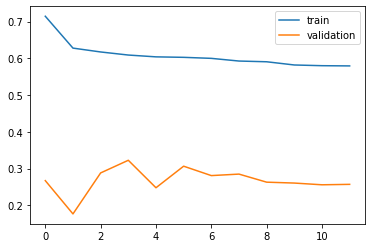


predict: [[31.18449567 23.1532764 ]]
real:      [[30.7 23.2]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7240 - mean_squared_error: 0.9013 - val_loss: 0.8120 - val_mean_squared_error: 0.6674
Epoch 2/1000
 - 1s - loss: 0.6446 - mean_squared_error: 0.7393 - val_loss: 0.8322 - val_mean_squared_error: 0.6931
Epoch 3/1000
 - 1s - loss: 0.6136 - mean_squared_error: 0.6612 - val_loss: 0.8611 - val_mean_squared_error: 0.7419
Epoch 4/1000
 - 1s - loss: 0.6073 - mean_squared_error: 0.6587 - val_loss: 0.9023 - val_mean_squared_error: 0.8142
Epoch 5/1000
 - 1s - loss: 0.6043 - mean_squared_error: 0.6550 - val_loss: 0.9028 - val_mean_squared_error: 0.8174
Epoch 6/1000
 - 1s - loss: 0.5988 - mean_squared_error: 0.6442 - val_loss: 0.9027 - val_mean_squared_error: 0.8234
Epoch 7/1000
 - 1s - loss: 0.5958 - mean_squared_error: 0.6439 - val_loss: 0.9164 - val_mean_squared_error: 0.9042
Epoch 8/1000
 - 1s - loss: 0.5914 - mean_squared_error: 0.6373 - val_loss: 0.8914 - va

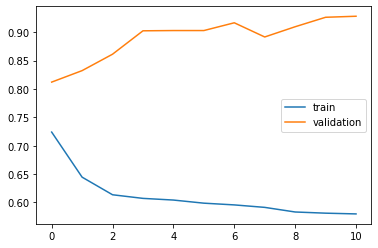


predict: [[30.72593953 22.94874361]]
real:      [[31.  22.7]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6763 - mean_squared_error: 0.7867 - val_loss: 0.5252 - val_mean_squared_error: 0.3275
Epoch 2/1000
 - 1s - loss: 0.6187 - mean_squared_error: 0.6764 - val_loss: 0.4217 - val_mean_squared_error: 0.2073
Epoch 3/1000
 - 1s - loss: 0.6095 - mean_squared_error: 0.6584 - val_loss: 0.3583 - val_mean_squared_error: 0.1537
Epoch 4/1000
 - 1s - loss: 0.6043 - mean_squared_error: 0.6550 - val_loss: 0.4339 - val_mean_squared_error: 0.2039
Epoch 5/1000
 - 1s - loss: 0.5996 - mean_squared_error: 0.6477 - val_loss: 0.3886 - val_mean_squared_error: 0.1605
Epoch 6/1000
 - 1s - loss: 0.5957 - mean_squared_error: 0.6417 - val_loss: 0.4292 - val_mean_squared_error: 0.1969
Epoch 7/1000
 - 1s - loss: 0.5907 - mean_squared_error: 0.6358 - val_loss: 0.4077 - val_mean_squared_error: 0.1752
Epoch 8/1000
 - 1s - loss: 0.5889 - mean_squared_error: 0.6238 - val_loss: 0.4760 - va

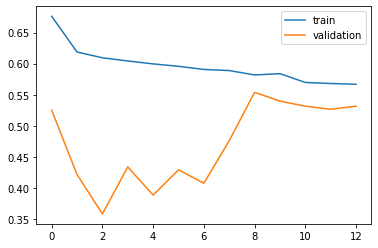


predict: [[31.51556398 23.18225502]]
real:      [[31.6 21.9]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6517 - mean_squared_error: 0.7393 - val_loss: 0.5754 - val_mean_squared_error: 0.4658
Epoch 2/1000
 - 1s - loss: 0.6187 - mean_squared_error: 0.6828 - val_loss: 0.5491 - val_mean_squared_error: 0.3681
Epoch 3/1000
 - 1s - loss: 0.6097 - mean_squared_error: 0.6601 - val_loss: 0.5520 - val_mean_squared_error: 0.3602
Epoch 4/1000
 - 1s - loss: 0.6078 - mean_squared_error: 0.6580 - val_loss: 0.5737 - val_mean_squared_error: 0.3838
Epoch 5/1000
 - 1s - loss: 0.6038 - mean_squared_error: 0.6522 - val_loss: 0.5537 - val_mean_squared_error: 0.4323
Epoch 6/1000
 - 1s - loss: 0.5965 - mean_squared_error: 0.6428 - val_loss: 0.5786 - val_mean_squared_error: 0.4613
Epoch 7/1000
 - 1s - loss: 0.5943 - mean_squared_error: 0.6370 - val_loss: 0.5732 - val_mean_squared_error: 0.5088
Epoch 8/1000
 - 1s - loss: 0.5919 - mean_squared_error: 0.6380 - val_loss: 0.5565 - va

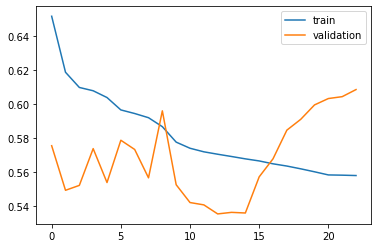


predict: [[31.49625176 23.14961721]]
real:      [[29.2 22.6]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7109 - mean_squared_error: 0.8826 - val_loss: 0.8564 - val_mean_squared_error: 0.7744
Epoch 2/1000
 - 1s - loss: 0.6234 - mean_squared_error: 0.6987 - val_loss: 0.8861 - val_mean_squared_error: 0.7965
Epoch 3/1000
 - 1s - loss: 0.6122 - mean_squared_error: 0.6714 - val_loss: 0.9228 - val_mean_squared_error: 0.8696
Epoch 4/1000
 - 1s - loss: 0.6087 - mean_squared_error: 0.6632 - val_loss: 0.9195 - val_mean_squared_error: 0.8632
Epoch 5/1000
 - 1s - loss: 0.6030 - mean_squared_error: 0.6558 - val_loss: 0.9403 - val_mean_squared_error: 0.9079
Epoch 6/1000
 - 1s - loss: 0.5973 - mean_squared_error: 0.6447 - val_loss: 0.9554 - val_mean_squared_error: 0.9838
Epoch 7/1000
 - 1s - loss: 0.5878 - mean_squared_error: 0.6291 - val_loss: 0.9728 - val_mean_squared_error: 1.0943
Epoch 8/1000
 - 1s - loss: 0.5895 - mean_squared_error: 0.6328 - val_loss: 0.9708 - va

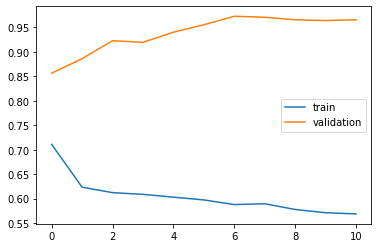


predict: [[31.19659896 23.14216563]]
real:      [[28.6 23.1]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6697 - mean_squared_error: 0.7598 - val_loss: 0.8077 - val_mean_squared_error: 0.6753
Epoch 2/1000
 - 1s - loss: 0.6211 - mean_squared_error: 0.6921 - val_loss: 0.8664 - val_mean_squared_error: 0.7647
Epoch 3/1000
 - 1s - loss: 0.6106 - mean_squared_error: 0.6727 - val_loss: 0.8689 - val_mean_squared_error: 0.7572
Epoch 4/1000
 - 1s - loss: 0.6054 - mean_squared_error: 0.6589 - val_loss: 0.8718 - val_mean_squared_error: 0.7633
Epoch 5/1000
 - 1s - loss: 0.5977 - mean_squared_error: 0.6507 - val_loss: 0.8743 - val_mean_squared_error: 0.7678
Epoch 6/1000
 - 1s - loss: 0.5920 - mean_squared_error: 0.6368 - val_loss: 0.8850 - val_mean_squared_error: 0.7847
Epoch 7/1000
 - 1s - loss: 0.5960 - mean_squared_error: 0.6448 - val_loss: 0.9103 - val_mean_squared_error: 0.8330
Epoch 8/1000
 - 1s - loss: 0.5885 - mean_squared_error: 0.6323 - val_loss: 0.9052 - va

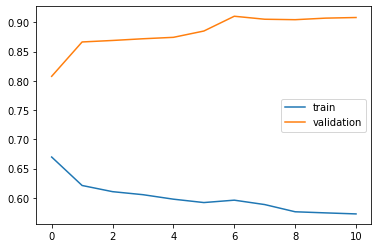


predict: [[31.24281817 23.28141945]]
real:      [[31.6 21.8]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7251 - mean_squared_error: 0.8704 - val_loss: 0.0666 - val_mean_squared_error: 0.0045
Epoch 2/1000
 - 1s - loss: 0.6430 - mean_squared_error: 0.7071 - val_loss: 0.0538 - val_mean_squared_error: 0.0041
Epoch 3/1000
 - 1s - loss: 0.6211 - mean_squared_error: 0.6814 - val_loss: 0.0358 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 1s - loss: 0.6153 - mean_squared_error: 0.6692 - val_loss: 0.0395 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 1s - loss: 0.6097 - mean_squared_error: 0.6593 - val_loss: 0.0970 - val_mean_squared_error: 0.0097
Epoch 6/1000
 - 1s - loss: 0.6055 - mean_squared_error: 0.6585 - val_loss: 0.1028 - val_mean_squared_error: 0.0126
Epoch 7/1000
 - 1s - loss: 0.6034 - mean_squared_error: 0.6500 - val_loss: 0.0743 - val_mean_squared_error: 0.0062
Epoch 8/1000
 - 1s - loss: 0.5984 - mean_squared_error: 0.6521 - val_loss: 0.0934 - va

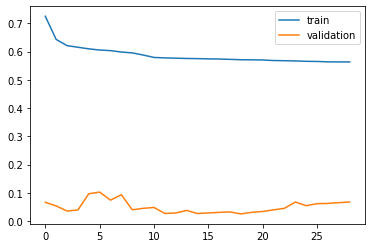


predict: [[31.64334774 23.18826857]]
real:      [[31.8 22. ]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6843 - mean_squared_error: 0.8040 - val_loss: 0.3674 - val_mean_squared_error: 0.2043
Epoch 2/1000
 - 1s - loss: 0.6232 - mean_squared_error: 0.6890 - val_loss: 0.3094 - val_mean_squared_error: 0.1510
Epoch 3/1000
 - 1s - loss: 0.6164 - mean_squared_error: 0.6798 - val_loss: 0.3425 - val_mean_squared_error: 0.1426
Epoch 4/1000
 - 1s - loss: 0.6101 - mean_squared_error: 0.6702 - val_loss: 0.3593 - val_mean_squared_error: 0.1442
Epoch 5/1000
 - 1s - loss: 0.6070 - mean_squared_error: 0.6602 - val_loss: 0.3848 - val_mean_squared_error: 0.1627
Epoch 6/1000
 - 1s - loss: 0.6015 - mean_squared_error: 0.6570 - val_loss: 0.3812 - val_mean_squared_error: 0.1626
Epoch 7/1000
 - 1s - loss: 0.5951 - mean_squared_error: 0.6450 - val_loss: 0.4124 - val_mean_squared_error: 0.1849
Epoch 8/1000
 - 1s - loss: 0.5871 - mean_squared_error: 0.6276 - val_loss: 0.3906 - va

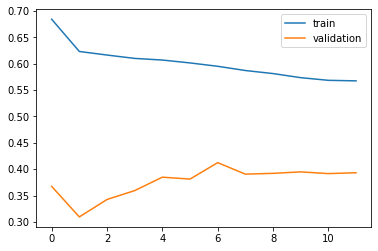


predict: [[31.33924119 23.2090844 ]]
real:      [[30.4 23. ]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6627 - mean_squared_error: 0.7594 - val_loss: 0.8766 - val_mean_squared_error: 0.7842
Epoch 2/1000
 - 1s - loss: 0.6211 - mean_squared_error: 0.6799 - val_loss: 0.8907 - val_mean_squared_error: 0.7991
Epoch 3/1000
 - 1s - loss: 0.6164 - mean_squared_error: 0.6728 - val_loss: 0.8387 - val_mean_squared_error: 0.7082
Epoch 4/1000
 - 1s - loss: 0.6122 - mean_squared_error: 0.6687 - val_loss: 0.8769 - val_mean_squared_error: 0.7716
Epoch 5/1000
 - 1s - loss: 0.6087 - mean_squared_error: 0.6615 - val_loss: 0.8663 - val_mean_squared_error: 0.7532
Epoch 6/1000
 - 1s - loss: 0.6071 - mean_squared_error: 0.6583 - val_loss: 0.9176 - val_mean_squared_error: 0.8437
Epoch 7/1000
 - 1s - loss: 0.6034 - mean_squared_error: 0.6541 - val_loss: 0.8786 - val_mean_squared_error: 0.7758
Epoch 8/1000
 - 1s - loss: 0.5964 - mean_squared_error: 0.6390 - val_loss: 0.8760 - va

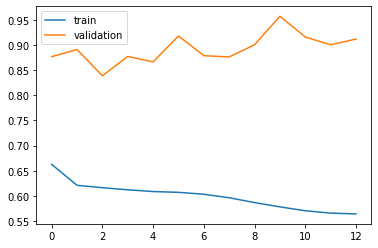


predict: [[31.84493118 23.35393269]]
real:      [[30.8 22.5]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6950 - mean_squared_error: 0.8114 - val_loss: 0.2806 - val_mean_squared_error: 0.0882
Epoch 2/1000
 - 1s - loss: 0.6287 - mean_squared_error: 0.6897 - val_loss: 0.1931 - val_mean_squared_error: 0.0436
Epoch 3/1000
 - 1s - loss: 0.6170 - mean_squared_error: 0.6772 - val_loss: 0.1883 - val_mean_squared_error: 0.0375
Epoch 4/1000
 - 1s - loss: 0.6111 - mean_squared_error: 0.6702 - val_loss: 0.2169 - val_mean_squared_error: 0.0488
Epoch 5/1000
 - 1s - loss: 0.6045 - mean_squared_error: 0.6597 - val_loss: 0.2622 - val_mean_squared_error: 0.0695
Epoch 6/1000
 - 1s - loss: 0.5986 - mean_squared_error: 0.6467 - val_loss: 0.2754 - val_mean_squared_error: 0.0759
Epoch 7/1000
 - 1s - loss: 0.5894 - mean_squared_error: 0.6338 - val_loss: 0.2951 - val_mean_squared_error: 0.0877
Epoch 8/1000
 - 1s - loss: 0.5781 - mean_squared_error: 0.6124 - val_loss: 0.3490 - va

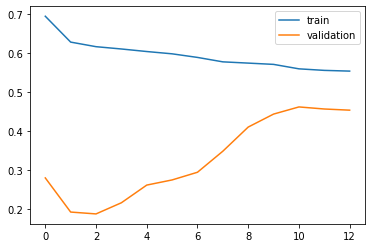


predict: [[31.68820044 23.41439548]]
real:      [[31.8 23.8]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6760 - mean_squared_error: 0.7823 - val_loss: 0.3359 - val_mean_squared_error: 0.1346
Epoch 2/1000
 - 1s - loss: 0.6279 - mean_squared_error: 0.7075 - val_loss: 0.3677 - val_mean_squared_error: 0.1971
Epoch 3/1000
 - 1s - loss: 0.6186 - mean_squared_error: 0.6913 - val_loss: 0.4159 - val_mean_squared_error: 0.2422
Epoch 4/1000
 - 1s - loss: 0.6136 - mean_squared_error: 0.6806 - val_loss: 0.4448 - val_mean_squared_error: 0.2720
Epoch 5/1000
 - 1s - loss: 0.6065 - mean_squared_error: 0.6706 - val_loss: 0.3886 - val_mean_squared_error: 0.2216
Epoch 6/1000
 - 1s - loss: 0.5982 - mean_squared_error: 0.6535 - val_loss: 0.4741 - val_mean_squared_error: 0.3002
Epoch 7/1000
 - 1s - loss: 0.5852 - mean_squared_error: 0.6258 - val_loss: 0.4579 - val_mean_squared_error: 0.2743
Epoch 8/1000
 - 1s - loss: 0.5799 - mean_squared_error: 0.6173 - val_loss: 0.4838 - va

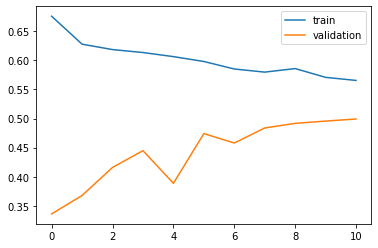


predict: [[31.58261795 23.29896353]]
real:      [[29.9 22.7]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7110 - mean_squared_error: 0.8403 - val_loss: 1.0425 - val_mean_squared_error: 1.2376
Epoch 2/1000
 - 1s - loss: 0.6281 - mean_squared_error: 0.7023 - val_loss: 0.9469 - val_mean_squared_error: 1.0380
Epoch 3/1000
 - 1s - loss: 0.6202 - mean_squared_error: 0.6852 - val_loss: 0.8926 - val_mean_squared_error: 0.9419
Epoch 4/1000
 - 1s - loss: 0.6148 - mean_squared_error: 0.6761 - val_loss: 0.8753 - val_mean_squared_error: 0.9273
Epoch 5/1000
 - 1s - loss: 0.6110 - mean_squared_error: 0.6742 - val_loss: 0.8894 - val_mean_squared_error: 0.9716
Epoch 6/1000
 - 1s - loss: 0.6078 - mean_squared_error: 0.6638 - val_loss: 0.8758 - val_mean_squared_error: 0.9646
Epoch 7/1000
 - 1s - loss: 0.6015 - mean_squared_error: 0.6543 - val_loss: 0.8650 - val_mean_squared_error: 0.9462
Epoch 8/1000
 - 1s - loss: 0.5948 - mean_squared_error: 0.6522 - val_loss: 0.8460 - va

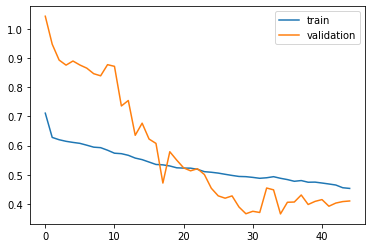


predict: [[31.59430796 23.35883652]]
real:      [[30.6 23.5]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7075 - mean_squared_error: 0.8631 - val_loss: 1.0623 - val_mean_squared_error: 1.4161
Epoch 2/1000
 - 1s - loss: 0.6332 - mean_squared_error: 0.7105 - val_loss: 1.1081 - val_mean_squared_error: 1.4991
Epoch 3/1000
 - 1s - loss: 0.6252 - mean_squared_error: 0.7007 - val_loss: 1.1599 - val_mean_squared_error: 1.6320
Epoch 4/1000
 - 1s - loss: 0.6199 - mean_squared_error: 0.6930 - val_loss: 1.1621 - val_mean_squared_error: 1.6036
Epoch 5/1000
 - 1s - loss: 0.6154 - mean_squared_error: 0.6808 - val_loss: 1.1961 - val_mean_squared_error: 1.7217
Epoch 6/1000
 - 1s - loss: 0.6061 - mean_squared_error: 0.6700 - val_loss: 1.2021 - val_mean_squared_error: 1.7287
Epoch 7/1000
 - 1s - loss: 0.5940 - mean_squared_error: 0.6543 - val_loss: 1.0856 - val_mean_squared_error: 1.4975
Epoch 8/1000
 - 1s - loss: 0.5860 - mean_squared_error: 0.6370 - val_loss: 1.0803 - va

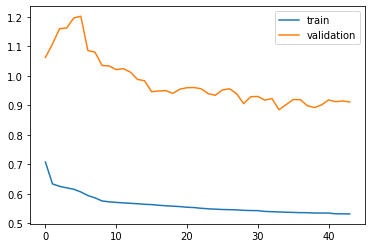


predict: [[31.39447588 23.2076762 ]]
real:      [[32.8 23.4]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6980 - mean_squared_error: 0.8114 - val_loss: 0.9902 - val_mean_squared_error: 0.9902
Epoch 2/1000
 - 1s - loss: 0.6363 - mean_squared_error: 0.7200 - val_loss: 0.9868 - val_mean_squared_error: 0.9761
Epoch 3/1000
 - 1s - loss: 0.6251 - mean_squared_error: 0.6960 - val_loss: 0.9525 - val_mean_squared_error: 0.9091
Epoch 4/1000
 - 1s - loss: 0.6218 - mean_squared_error: 0.6928 - val_loss: 1.0150 - val_mean_squared_error: 1.0327
Epoch 5/1000
 - 1s - loss: 0.6147 - mean_squared_error: 0.6790 - val_loss: 1.0698 - val_mean_squared_error: 1.1468
Epoch 6/1000
 - 1s - loss: 0.6134 - mean_squared_error: 0.6806 - val_loss: 1.0803 - val_mean_squared_error: 1.1711
Epoch 7/1000
 - 1s - loss: 0.6074 - mean_squared_error: 0.6675 - val_loss: 1.0429 - val_mean_squared_error: 1.0955
Epoch 8/1000
 - 1s - loss: 0.5946 - mean_squared_error: 0.6443 - val_loss: 1.0745 - va

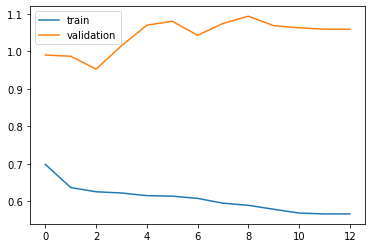


predict: [[31.49937183 23.32970655]]
real:      [[33.4 23.6]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7016 - mean_squared_error: 0.8475 - val_loss: 1.2361 - val_mean_squared_error: 1.7940
Epoch 2/1000
 - 1s - loss: 0.6347 - mean_squared_error: 0.7186 - val_loss: 1.3864 - val_mean_squared_error: 2.1943
Epoch 3/1000
 - 1s - loss: 0.6243 - mean_squared_error: 0.6947 - val_loss: 1.3905 - val_mean_squared_error: 2.2440
Epoch 4/1000
 - 1s - loss: 0.6187 - mean_squared_error: 0.6865 - val_loss: 1.4223 - val_mean_squared_error: 2.3554
Epoch 5/1000
 - 1s - loss: 0.6164 - mean_squared_error: 0.6821 - val_loss: 1.4893 - val_mean_squared_error: 2.5523
Epoch 6/1000
 - 1s - loss: 0.6067 - mean_squared_error: 0.6664 - val_loss: 1.5045 - val_mean_squared_error: 2.6541
Epoch 7/1000
 - 1s - loss: 0.5990 - mean_squared_error: 0.6513 - val_loss: 1.4261 - val_mean_squared_error: 2.3752
Epoch 8/1000
 - 1s - loss: 0.5869 - mean_squared_error: 0.6303 - val_loss: 1.4378 - va

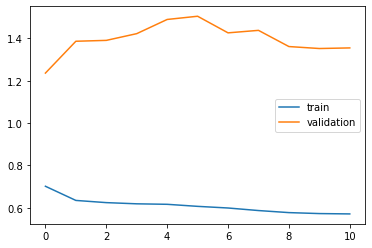


predict: [[31.32364921 23.238984  ]]
real:      [[32.2 23.8]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7238 - mean_squared_error: 0.8894 - val_loss: 0.6025 - val_mean_squared_error: 0.3663
Epoch 2/1000
 - 1s - loss: 0.6339 - mean_squared_error: 0.7041 - val_loss: 0.6264 - val_mean_squared_error: 0.3957
Epoch 3/1000
 - 1s - loss: 0.6259 - mean_squared_error: 0.7014 - val_loss: 0.7540 - val_mean_squared_error: 0.5772
Epoch 4/1000
 - 1s - loss: 0.6184 - mean_squared_error: 0.6852 - val_loss: 0.7929 - val_mean_squared_error: 0.6364
Epoch 5/1000
 - 1s - loss: 0.6136 - mean_squared_error: 0.6768 - val_loss: 0.7797 - val_mean_squared_error: 0.6127
Epoch 6/1000
 - 1s - loss: 0.6029 - mean_squared_error: 0.6612 - val_loss: 0.7615 - val_mean_squared_error: 0.5831
Epoch 7/1000
 - 1s - loss: 0.5961 - mean_squared_error: 0.6512 - val_loss: 0.7857 - val_mean_squared_error: 0.6204
Epoch 8/1000
 - 1s - loss: 0.5850 - mean_squared_error: 0.6321 - val_loss: 0.7472 - va

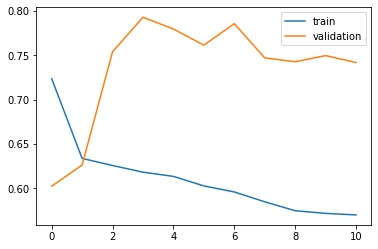


predict: [[30.71949885 22.87861024]]
real:      [[34.  23.7]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6886 - mean_squared_error: 0.8046 - val_loss: 0.5192 - val_mean_squared_error: 0.2708
Epoch 2/1000
 - 1s - loss: 0.6367 - mean_squared_error: 0.7171 - val_loss: 0.5156 - val_mean_squared_error: 0.2668
Epoch 3/1000
 - 1s - loss: 0.6271 - mean_squared_error: 0.7027 - val_loss: 0.5669 - val_mean_squared_error: 0.3219
Epoch 4/1000
 - 1s - loss: 0.6244 - mean_squared_error: 0.7002 - val_loss: 0.5932 - val_mean_squared_error: 0.3531
Epoch 5/1000
 - 1s - loss: 0.6133 - mean_squared_error: 0.6791 - val_loss: 0.6408 - val_mean_squared_error: 0.4155
Epoch 6/1000
 - 1s - loss: 0.6009 - mean_squared_error: 0.6566 - val_loss: 0.6966 - val_mean_squared_error: 0.4886
Epoch 7/1000
 - 1s - loss: 0.5992 - mean_squared_error: 0.6537 - val_loss: 0.6169 - val_mean_squared_error: 0.3950
Epoch 8/1000
 - 1s - loss: 0.5859 - mean_squared_error: 0.6366 - val_loss: 0.5017 - va

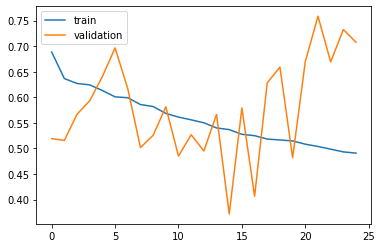


predict: [[30.80271869 23.1211394 ]]
real:      [[31.6 23.7]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.7251 - mean_squared_error: 0.9197 - val_loss: 0.3953 - val_mean_squared_error: 0.1593
Epoch 2/1000
 - 1s - loss: 0.6391 - mean_squared_error: 0.7221 - val_loss: 0.3809 - val_mean_squared_error: 0.1472
Epoch 3/1000
 - 1s - loss: 0.6295 - mean_squared_error: 0.7149 - val_loss: 0.4038 - val_mean_squared_error: 0.1652
Epoch 4/1000
 - 1s - loss: 0.6263 - mean_squared_error: 0.7034 - val_loss: 0.3953 - val_mean_squared_error: 0.1666
Epoch 5/1000
 - 1s - loss: 0.6237 - mean_squared_error: 0.7027 - val_loss: 0.3777 - val_mean_squared_error: 0.1531
Epoch 6/1000
 - 1s - loss: 0.6151 - mean_squared_error: 0.6822 - val_loss: 0.3328 - val_mean_squared_error: 0.1113
Epoch 7/1000
 - 1s - loss: 0.6093 - mean_squared_error: 0.6742 - val_loss: 0.3557 - val_mean_squared_error: 0.1345
Epoch 8/1000
 - 1s - loss: 0.5952 - mean_squared_error: 0.6460 - val_loss: 0.3351 - va

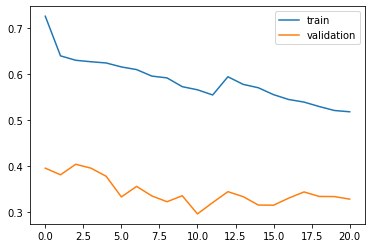


predict: [[30.58271085 22.73941814]]
real:      [[31.6 23.4]]

Train on 1734 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 0.6940 - mean_squared_error: 0.8271 - val_loss: 0.3163 - val_mean_squared_error: 0.1024
Epoch 2/1000
 - 1s - loss: 0.6382 - mean_squared_error: 0.7193 - val_loss: 0.4066 - val_mean_squared_error: 0.1673
Epoch 3/1000
 - 1s - loss: 0.6283 - mean_squared_error: 0.7107 - val_loss: 0.3542 - val_mean_squared_error: 0.1257
Epoch 4/1000
 - 1s - loss: 0.6231 - mean_squared_error: 0.7052 - val_loss: 0.4086 - val_mean_squared_error: 0.1671
Epoch 5/1000
 - 1s - loss: 0.6170 - mean_squared_error: 0.6842 - val_loss: 0.3984 - val_mean_squared_error: 0.1592
Epoch 6/1000
 - 1s - loss: 0.6090 - mean_squared_error: 0.6680 - val_loss: 0.4031 - val_mean_squared_error: 0.1628
Epoch 7/1000
 - 1s - loss: 0.6061 - mean_squared_error: 0.6641 - val_loss: 0.3486 - val_mean_squared_error: 0.1231
Epoch 8/1000
 - 1s - loss: 0.5990 - mean_squared_error: 0.6519 - val_loss: 0.3599 - va

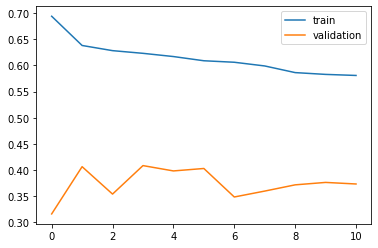


predict: [[30.78478697 23.05846801]]
real:      [[29.9 23.3]]

Train on 1733 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.7399 - mean_squared_error: 0.9258 - val_loss: 0.5399 - val_mean_squared_error: 0.3015
Epoch 2/1000
 - 1s - loss: 0.6416 - mean_squared_error: 0.7477 - val_loss: 0.6364 - val_mean_squared_error: 0.4077
Epoch 3/1000
 - 1s - loss: 0.6314 - mean_squared_error: 0.7139 - val_loss: 0.6968 - val_mean_squared_error: 0.4883
Epoch 4/1000
 - 1s - loss: 0.6220 - mean_squared_error: 0.7024 - val_loss: 0.7234 - val_mean_squared_error: 0.5270
Epoch 5/1000
 - 1s - loss: 0.6102 - mean_squared_error: 0.6809 - val_loss: 0.7462 - val_mean_squared_error: 0.5630
Epoch 6/1000
 - 0s - loss: 0.5982 - mean_squared_error: 0.6527 - val_loss: 0.7693 - val_mean_squared_error: 0.6049
Epoch 7/1000
 - 1s - loss: 0.5864 - mean_squared_error: 0.6278 - val_loss: 0.7165 - val_mean_squared_error: 0.5249
Epoch 8/1000
 - 1s - loss: 0.5770 - mean_squared_error: 0.6083 - val_loss: 0.5591 - va

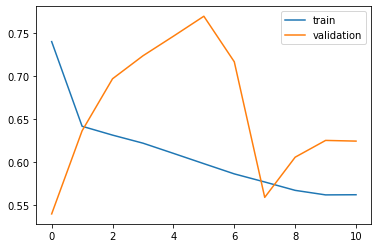


predict: [[30.62540197 22.92022269]]
real:      [[29.9 22.6]]

Train and validation time: 10.192978890736898

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 1.945
Test STANDART-DEVIATION ------------ 0.8396
Test MEAN-ABSOLUTE-ERROR ----------- 1.114
Test MEDIAN-ABSOLUTE-ERROR --------- 0.9032

Errors
2018-12-31 = 0.3515233998762106
2018-12-30 = 2.213325034027246
2018-12-29 = 2.3539213652890076
2018-12-28 = 1.935321779403715
2018-12-27 = 1.9754477905432424
2018-12-26 = 0.6273806911322453
2018-12-25 = 0.9215752494769625
2018-12-24 = 0.6021601846431217
2018-12-23 = 0.1640066677366292
2018-12-22 = 0.3562389506466488
2018-12-21 = 0.48449567449308617
2018-12-20 = 0.274060471771822
2018-12-19 = 0.08443602123140082
2018-12-18 = 2.2962517643591873
2018-12-17 = 2.5965989641753744
2018-12-16 = 0.3571818308653647
2018-12-15 = 0.15665226105770813
2018-12-14 = 0.9392411862676084
2018-12-13 = 1.0449311787330302
2018-12-12 = 0.11179955831647348
2018-12-11 = 1.6826179528893555
2018-

In [16]:
def main():
    input_path = '../data_in/'+city+'.csv'
    output_path = format_dataset(input_path)
    dataset = load_dataset(output_path)
    values = dataset.values
    plot_columns(dataset, values)

    # to get index the last 30 days
    days_to_predict = list(dataset.index[-30:])

    standart_scaler = preprocessing.StandardScaler()
    values_scaled = standart_scaler.fit_transform(values)
    dataset_scaled = DataFrame(values_scaled)
    dataset_scaled.index = dataset.index
    dataset_scaled.columns = dataset.columns

    inicio = time.time()
    result = NCV(dataset_scaled, days_to_predict, standart_scaler)
    fim = time.time()
    print('Train and validation time: {}\n'.format((fim - inicio)/60))

    y_hats = result[0]
    y_tests = result[1]

    metrics(y_hats, y_tests, days_to_predict)
    
if __name__ == "__main__":
    main()